<a href="https://colab.research.google.com/github/setareh-roshan/EEG-Analysis/blob/main/EOEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install MNE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import mne
import numpy as np
from scipy.signal import find_peaks, welch
import matplotlib.pyplot as plt

In [ ]:
file_path = "/content/33_Eye.txt"
df = pd.read_csv(file_path, delim_whitespace=True, header=0)

print(df.head())

      O2     T8   EARR  CH33
0  13.19  -3.70  -0.84   0.0
1  18.15  -4.89   3.48   0.0
2  21.98  -7.52   8.68   0.0
3  25.81 -10.74  11.78   0.0
4  30.91 -12.44  11.05   0.0


<ipython-input-10-a8ccf40c188c>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=0)


In [ ]:
data = df.to_numpy().T

data = data.astype(float)

In [ ]:
ch_names = []
for i, col in enumerate(df.columns): ch_names.append(col)
ch_types = ['eeg'] * (len(ch_names) - 1) + ['stim']
sfreq = 500
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=4, n_times=133785
    Range : 0 ... 133784 =      0.000 ...   267.568 secs
Ready.


In [ ]:
raw.notch_filter(freqs=[50, 100, 150, 200])

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



<RawArray | 4 x 133785 (267.6 s), ~4.1 MiB, data loaded>

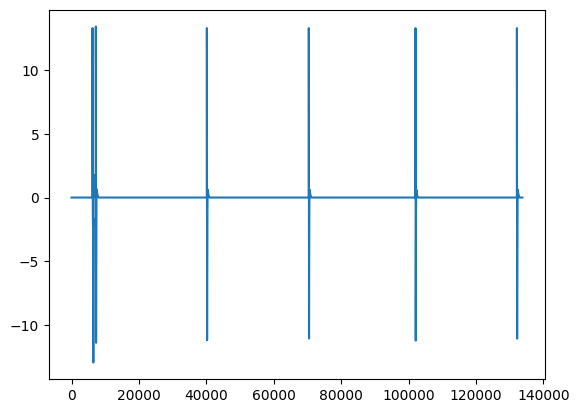

In [ ]:
plt.plot(raw.get_data()[-1,:])

In [ ]:
def findingAnnotations(trigger_channel, TOI, error, sfreq):
    """
    Identifies peaks in the trigger channel that occur at intervals matching the time of interest (TOM),
    with a margin of error.

    Parameters:
    - trigger_channel (array-like): Input signal to analyze for trigger events.
    - TOI (float): Time of interest in seconds (e.g., checking for events occurring every 60 seconds).
    - error (float): Acceptable error margin in seconds.
    - sfreq (float): Sampling frequency of the signal in Hz.

    Returns:
    - array: Indices of peaks in the trigger_channel that occur within the specified timing window.
    """

    # Find all peaks in the trigger channel
    peaks, _ = find_peaks(trigger_channel)

    # Calculate the time differences between consecutive peaks (in seconds)
    diff_of_elements = np.diff(peaks) / sfreq

    # Identify indices of peaks where the time differences match the time of interest (TOI ± error)
    event_indices = np.where((diff_of_elements > TOI - error) & (diff_of_elements <= TOI + error))[0]

    # Return the peaks corresponding to the matched event indices
    return peaks[event_indices]

In [ ]:
events = findingAnnotations(raw.get_data()[-1,:], 60, 6, sfreq)
events = np.column_stack((events, np.zeros(len(events), dtype=int), np.ones(len(events), dtype=int)))

In [ ]:
events

array([[  7482,      0,      1],
       [ 40421,      0,      1],
       [ 70675,      0,      1],
       [102330,      0,      1]])

In [ ]:
epochs = mne.Epochs(raw, events=events, tmin=1, tmax=60, baseline=None)

Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
psd, freqs = mne.time_frequency.psd_array_welch(epochs.get_data(), sfreq=500, fmin=0.5, fmax=50, n_fft = 1000, n_per_seg = 2000)

Using data from preloaded Raw for 4 events and 14001 original time points ...
0 bad epochs dropped
Effective window size : 2.000 (s)


In [ ]:
psd.shape

(4, 4, 100)

<ipython-input-31-59d04f3f0e90>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


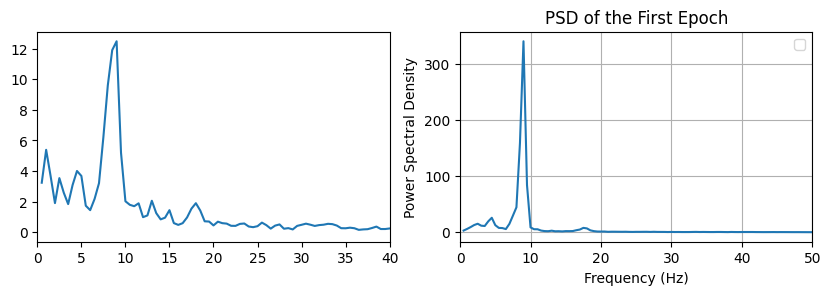

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(2,2,1)
plt.plot(freqs, psd[2,1,:], label='')
plt.xlim(0,40)  # PSD of the first epoch
plt.subplot(2,2,2)
plt.plot(freqs, psd[2,0,:], label='')  # PSD of the first epoch
plt.xlim(0,50)
plt.title('PSD of the First Epoch')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [ ]:
def calculate_alpha_ratio(signal, fs, alpha_band=(8, 12), total_band=(0.5, 50)):
    """
    Calculate the alpha power ratio of a signal.

    Parameters:
        signal (array): The input signal.
        fs (float): Sampling frequency in Hz.
        alpha_band (tuple): Frequency range for the alpha band (low, high) in Hz.
        total_band (tuple): Frequency range for the total power calculation (low, high) in Hz.

    Returns:
        alpha_ratio (float): Ratio of alpha band power to total power.
    """
    # Compute the PSD using Welch's method
    freqs, psd = welch(signal, fs=fs, nperseg=2000)

    # Calculate alpha band power
    alpha_indices = np.logical_and(freqs >= alpha_band[0], freqs <= alpha_band[1])
    alpha_power = np.trapz(psd[alpha_indices], freqs[alpha_indices])

    # Calculate total power
    total_indices = np.logical_and(freqs >= total_band[0], freqs <= total_band[1])
    total_power = np.trapz(psd[total_indices], freqs[total_indices])

    # Calculate alpha ratio
    alpha_ratio = alpha_power / total_power

    return alpha_power, alpha_ratio

We need to calculate the alpha power of EyeClose to EyeOpen. To do so, in the next cells, first the alpha power of EyeClose (even epochs) is calculated, second the power of EyeClose is calculated (odd epochs).


The dimension of the epochs data is 3. The first dimension demonstrates the channel_number, the second dimensions shows the epoch number, and the last one are data_ponits in that specific epoch.

In [ ]:
alpha_ratio_whole = np.zeros((2,len(raw.ch_names)-1), dtype = 'float32')
for i in range(len(raw.ch_names)-1):
    alpha_power_EC, alpha_ratio_EC = calculate_alpha_ratio(epochs.get_data()[i,0,:], sfreq)
    alpha_power_EO, alpha_ratio_EO = calculate_alpha_ratio(epochs.get_data()[i,1,:], sfreq)

    alpha_ratio_whole[0, i] = alpha_ratio_EC/alpha_ratio_EO

    alpha_power_EC, alpha_ratio_EC = calculate_alpha_ratio(epochs.get_data()[i,2,:], sfreq)
    alpha_power_EO, alpha_ratio_EO = calculate_alpha_ratio(epochs.get_data()[i,3,:], sfreq)

    alpha_ratio_whole[1, i] = alpha_ratio_EC/alpha_ratio_EO


Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...
Using data from preloaded Raw for 4 events and 14001 original time points ...


2*Ch_number  and 2 is:
0----> two first epochs (close/open)
1----> two second epochs (close/open)

In [ ]:
alpha_ratio_whole

array([[2.493456 , 1.64513  , 2.378447 ],
       [1.3944534, 1.1658449, 1.2589406]], dtype=float32)

In [ ]:
raw.ch_names

['O2', 'T8', 'EARR', 'CH33']

In [ ]:
alpha_power_EC, alpha_ratio_EC = calculate_alpha_ratio(epochs.get_data()[2,2,:], sfreq)
print("Alpha Ratio in :", alpha_ratio_EC)

Using data from preloaded Raw for 4 events and 14001 original time points ...
Alpha Ratio in : 0.200237797217038


In [ ]:
alpha_power_EO, alpha_ratio_EO = calculate_alpha_ratio(epochs.get_data()[2,3,:], sfreq)
print("Alpha Ratio in :", alpha_ratio_EO)

Using data from preloaded Raw for 4 events and 14001 original time points ...
Alpha Ratio in : 0.15905261752315933


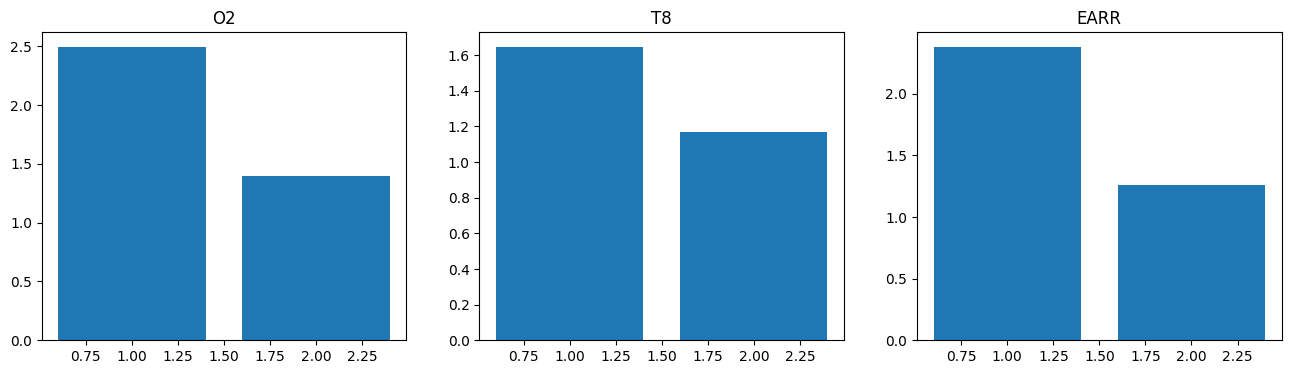

In [ ]:
plt.figure(figsize = (16,4))
for i in range(len(raw.ch_names)-1):

  plt.subplot(1,len(raw.ch_names)-1,i+1)

  plt.title(raw.ch_names[i])
  plt.bar([1,2],alpha_ratio_whole[:,i])